In [1]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import wordnet
from nltk import WordNetLemmatizer
lem = WordNetLemmatizer()
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [2]:
df = pd.read_csv('amazon_reviews.csv',index_col=0)

In [3]:
df.head(2)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,50423057,R135Q3VZ4DQN5N,B00JWXFDMG,657335467,Everbling Purple and Clear Briolette Drop Swar...,Jewelry,5,0,0,N,Y,Beauties!,so beautiful even tho clearly not high end ......,2015-08-31
1,US,11262325,R2N0QQ6R4T7YRY,B00W5T1H9W,26030170,925 Sterling Silver Finish 6ct Simulated Diamo...,Jewelry,5,0,0,N,N,Great product.,"Great product.. I got this set for my mother, ...",2015-08-31


In [4]:
data = df[['review_body']]

In [5]:
def contractions(s):
    s = re.sub(r"won't", "will not",s)
    s = re.sub(r"would't", "would not",s)
    s = re.sub(r"could't", "could not",s)
    s = re.sub(r"\'d", " would",s)
    s = re.sub(r"can\'t", "can not",s)
    s = re.sub(r"n\'t", " not", s)
    s= re.sub(r"\'re", " are", s)
    s = re.sub(r"\'s", " is", s)
    s = re.sub(r"\'ll", " will", s)
    s = re.sub(r"\'t", " not", s)
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"\'m", " am", s)
    return s

In [6]:
def pos_tag_simplified(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [7]:
data['pre_process'] = data['review_body'].apply(lambda x: ' '.join(x.lower() for x in str(x).split()))

In [8]:
data['pre_process']=data['pre_process'].apply(lambda x:contractions(x))

In [9]:
data['pre_process'] = data['pre_process'].apply(lambda x: ' '.join([re.sub('[^A-z]+','',x) for x in nltk.word_tokenize(x)]))

In [10]:
data['pre_process'] = data['pre_process'].apply(lambda x: ' '.join([re.sub('-','',x) for x in nltk.word_tokenize(x)]))

In [11]:
data['pre_process'] = data['pre_process'].apply(lambda x: ' '.join([re.sub('_','',x) for x in nltk.word_tokenize(x)]))

In [12]:
data['pre_process'] = data['pre_process'].apply(lambda x: re.sub(' +',' ',x))

In [13]:
stop = nltk.corpus.stopwords.words('english')
data['pre_process'] = data['pre_process'].apply(lambda x: ' '.join([x for x in x.split() if x not in stop]))

In [14]:
tagged = nltk.pos_tag(data['pre_process'])

In [15]:
simple_tagged = list(map(lambda x:(x[0],pos_tag_simplified(x[1])),tagged))

In [16]:
lemmatized_ = [lem.lemmatize(i[0],i[1]) if i[1] != None else lem.lemmatize(i[0]) for i in simple_tagged]

In [17]:
data['pre_process'] = lemmatized_

In [18]:
data['pre_process'] = data['pre_process'].apply(lambda x: BeautifulSoup(x).get_text())
data['pre_process'] = data['pre_process'].apply(lambda x: re.sub(r'http\S+','',x))

In [19]:
data['pre_process'] = [i.replace('<br>', '').replace('</br>', '').replace('br','') for i in data['pre_process']]

In [20]:
data[['pre_process']].to_csv('processed_amazonreviews.csv',index=False)

In [21]:
words = nltk.word_tokenize(str(data['pre_process'].values.tolist()))
words = [i.lower() for i in words if i.isalpha()]

In [22]:
freq = nltk.FreqDist(words)

In [23]:
df_freq = pd.DataFrame.from_dict([freq]).T
df_freq.columns=['words']

Text(0, 0.5, 'count of word')

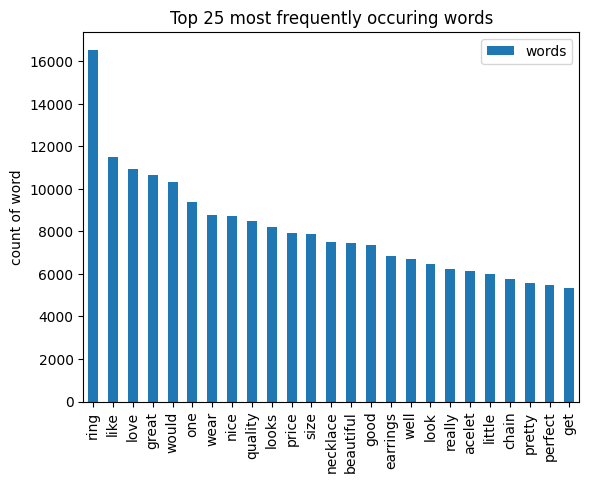

In [24]:
df_freq.sort_values(by='words',ascending=False)[:25]\
.plot(kind='bar',title='Top 25 most frequently occuring words')
plt.ylabel('count of word')

In [25]:
sent = data['pre_process'].values.tolist()
wpd = np.array(list(map(lambda x: len(x.split()),sent)))

In [26]:
df_wpd = pd.DataFrame({'num_of_words':wpd},index=np.arange(len(data)))

Text(0, 0.5, 'Number of words')

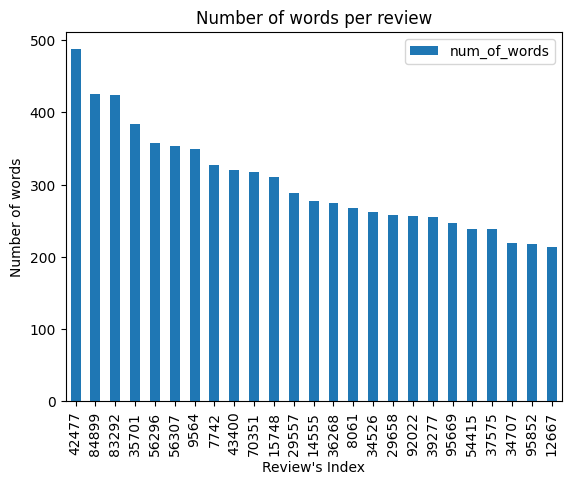

In [27]:
df_wpd.sort_values(by='num_of_words',ascending=False)[:25].plot(kind='bar',title='Number of words per review')
plt.xlabel('Review\'s Index')
plt.ylabel('Number of words')

In [28]:
print('The Average number of words in a review is around {}'.format(int(np.mean(wpd))))

The Average number of words in a review is around 11


In [29]:
txt = str(data['pre_process'].values)

(-0.5, 399.5, 199.5, -0.5)

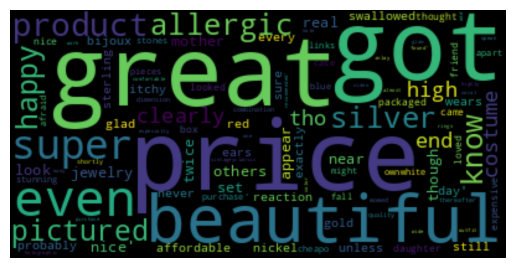

In [30]:
wcd = WordCloud(background_color=None,max_words=100).generate(txt)
plt.imshow(wcd,interpolation='gaussian')
plt.axis('off')

In [44]:
vec = TfidfVectorizer(use_idf=True)

In [45]:
x = vec.fit_transform(data['pre_process'])

In [46]:
wcss = []
for i in range(1,5):
    clustering = KMeans(n_clusters=i,init='k-means++',random_state=42)
    clustering.fit(x)
    wcss.append(clustering.inertia_)
ks = [1,2,3,4]

<AxesSubplot: >

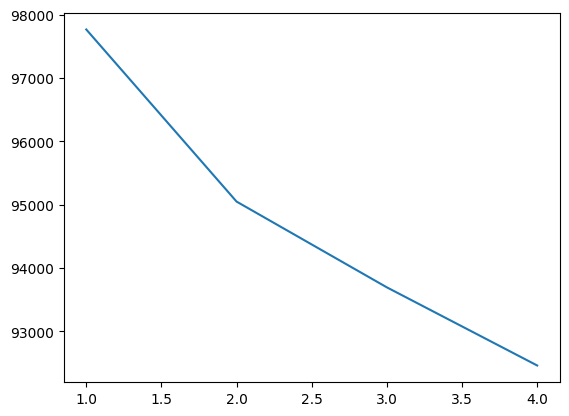

In [47]:
sns.lineplot(x=ks,y=wcss)

In [48]:
model = KMeans(n_clusters=2,init='k-means++',max_iter=100,n_init=1)
model.fit(x)

KMeans(max_iter=100, n_clusters=2, n_init=1)

In [49]:
print('Top terms per cluster:')
order_centroids = model.cluster_centers_.argsort()[:,::-1]
terms = vec.get_feature_names_out()
for i in range(2):
    print('Cluster %d:'%i)
    for ind in order_centroids[i,:5]:
        print(' %s '%terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 perfect 
 size 
 love 
 fit 
 beautiful 


Cluster 1:
 love 
 nice 
 beautiful 
 great 
 ring 




In [50]:
def cluster_tag(txt):
    we = vec.transform([txt])
    return model.predict(we)[0]

In [51]:
clusters = data['pre_process'].apply(lambda x: cluster_tag(x))

In [52]:
clusters.unique()

array([1, 0], dtype=int32)

In [53]:
fin_df = pd.DataFrame({'processed_reviews':data['pre_process'],'cluster_num':clusters})

In [54]:
fin_df['cluster'] = np.where(fin_df['cluster_num']==0,'reviews about the product\'s quality','reviews about the product\'s appearance')

In [55]:
fin_df.head()

,processed_reviews,cluster_num,cluster
0,beautiful even tho clearly high end super grea...,1,reviews about the product's appearance
1,great product got set mother allergic bijoux p...,1,reviews about the product's appearance
2,exactly pictured daughter friend loved came pa...,1,reviews about the product's appearance
3,love fits great super comfortable neat idea fi...,1,reviews about the product's appearance
4,got mother day gift mom loved really nice qual...,1,reviews about the product's appearance


In [56]:
fin_df[fin_df['cluster_num'] == 0]

,processed_reviews,cluster_num,cluster
8,perfect,0,reviews about the product's quality
119,item perfect pictured,0,reviews about the product's quality
172,perfect,0,reviews about the product's quality
189,perfect needed fit size definitely look feel c...,0,reviews about the product's quality
303,perfect,0,reviews about the product's quality
...,...,...,...
99831,love perfect,0,reviews about the product's quality
99845,pleased necklace true picture perfect size,0,reviews about the product's quality
99858,got gift perfect,0,reviews about the product's quality
99892,fits perfect buy opk great quality,0,reviews about the product's quality
